In [1]:
from pathlib import Path

In [2]:
# local path to Allen Visual Coding dataset. This is where the image data will be downloaded.
MANIFEST_PATH = "C:/Users/lesliec/code/visual_encoding/manifest.json" # SET THIS TO YOUR LOCAL PATH

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import rcParams
from scipy.fftpack import fft2, ifftshift
from scipy.signal import welch
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
# from specparam import SpectralModel

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from PIL import Image

In [4]:
%matplotlib notebook

#### Settings

In [5]:
# dataset details
N_SCENES = 118
DATASET_1 = np.arange(58)
DATASET_2 = np.arange(58,101)
DATASET_3 = np.arange(101,N_SCENES)

In [6]:
# plotting settings

# font sizes
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12
rcParams["legend.fontsize"] = 12

#### Functions

In [7]:
# plotting functions

def show_image(image):
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()


def plot_results(image, ft, ft_freqs, sm):
    fig = plt.figure(figsize=(12, 4))
    spec = gs.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1.5, 1, 1])

    # plot image
    ax0 = plt.subplot(spec[0, 0])
    ax0.imshow(image, cmap='gray')
    ax0.set_title('Image')
    ax0.axis('off')

    # plot FT
    ax1 = plt.subplot(spec[0, 1])
    ax1.set_title('Fourier Transform')
    ax1.pcolormesh(ft_freqs[0], ft_freqs[1], np.log(np.abs(ft)**2).T, cmap='gray', shading='auto')
    ax1.set(xlabel='frequency (cycles/image)', ylabel='frequency (cycles/image)')

    # plot spectral model fit to 1d power spectrum
    ax2 = plt.subplot(spec[0, 2])
    sm.plot(ax=ax2, show=False, plt_log=True)
    ax2.set_title('Power Spectrum')
    ax2.legend().remove()
    ax2.grid(False)
    exponent = sm.get_params('aperiodic', 'exponent')
    ax2.text(0.1, 0.1, f'Exponent: {exponent:.2f}', horizontalalignment='left', 
            verticalalignment='center', transform=ax2.transAxes, fontsize=14,
            color='r')
    
    plt.show()

In [8]:
# analysis functions


def analyze_image(image, plot=False):
    """Compute the spectral exponent of an image.
    1. Preprocess the image by applying a Gaussian window.
    2. Compute the 2D Fourier transform of the windowed image.
    3. Compute the 1D power spectrum via azimuthal integration 
      of the 2D FFT.
    4. Compute the spectral exponent by fitting a 1/f^exponent 
      model to the 1D power spectrum.
    5. Optionally, plot the image, its FT, and its 1D power spectrum.

    Parameters
    ----------
    image : array_like
      The image to transform.
    plot : bool
      If True, plot the image, its FT, and its 1D power spectrum.

    Returns
    -------
    exponent : float
      The exponent of the 1D power spectrum of the image.
    r_squared : float
      The r-squared value of the spectral model fit.
    """

    # Preprocess the image
    image_p = window_image(image)

    # Compute the 2D Fourier transform of the image
    ft, ft_freqs = fft_2d(image_p)

    # Compute the 1D power spectrum from the 2D FT
    spectrum, freqs = ft_to_spectrum(ft, ft_freqs)

    # Parameterize the 1D power spectrum
    sm = SpectralModel(aperiodic_mode='fixed', verbose=False, max_n_peaks=0)
    sm._check_freqs=False
    sm.fit(freqs, spectrum)
    
    # Get spectral parameters
    exponent = sm.get_params('aperiodic_params', 'exponent')
    r_squared = sm.get_params('r_squared')

    # plot
    if plot:
      plot_results(image, ft, ft_freqs, sm)

    # return
    return exponent, r_squared


def window_image(image):
  """
  Apply Gaussian window to image.
  """
  
  # create gaussian window 
  width, height = image.shape
  gauss_window = gassian_2d(size=[height, width], center=[height//2, width//2], 
                            sigma=np.min(image.shape)//3)
  
  # apply window
  image = image * gauss_window

  return image


def gassian_2d(size=[918,1184], center=[459,587], sigma=1):
    """
    Make a square gaussian kernel.

    Parameters
    ----------
    size : int, array_like
        Size of the gaussian kernel
    center : float
        Center of the gaussian kernel
    sigma: float
        Standard deviation of the gaussian kernel

    Returns
    -------
    gaussian : ndarray
        2D gaussian kernel
    """

    x_arr = np.arange(0,size[0], 1, float)
    y_arr = np.arange(0,size[1], 1, float)[:,np.newaxis]

    gaussian = np.exp(-(((x_arr-center[0])**2)/(2*(sigma**2)) + \
                        ((y_arr-center[1])**2) /(2*(sigma**2))))

    return gaussian


def fft_2d(image):
    """Compute the 2D Fourier transform of an image.

    Parameters
    ----------
    image : array_like
      The image to transform.

    Returns
    -------
    ft : ndarray
      The 2D Fourier transform of the image.
      
    """

    # Compute the 2D Fourier transform.
    ft = fft2(image)

    # Shift the Fourier transform so that the origin is at the center.
    ft = ifftshift(ft)

    # define the frequency axes (in cycles/image)
    freqs_x = np.fft.fftshift(np.fft.fftfreq(image.shape[0])) * image.shape[0]
    freqs_y = np.fft.fftshift(np.fft.fftfreq(image.shape[1])) * image.shape[1]
    freqs = np.meshgrid(freqs_x, freqs_y)

    return ft, freqs


def ft_to_spectrum(ft, freqs):
  """
  Compute the 1D power spectral density (PSD) from a 2D Fourier transform.
  Performs azimuthal integration of the 2D FT.
  
  Parameters
  ----------
  ft : array_like
    The 2D Fourier transform of an image.

  Returns
  -------
  spectrum : ndarray
    1D power spectral density of the image.
  """
  
  # imports
  from scipy import ndimage

  # compute the radial distance from the center for each pixel
  radius_grid = np.hypot(freqs[0], freqs[1])
  radius = np.sort(np.unique(radius_grid))

  # compute power as squared magnitude of FT
  power = np.abs(ft)**2

  # azimuthal integration: sum power values at equal distance from the center (upper triangle only)
  spectrum = ndimage.sum(np.triu(power), radius_grid.T, index=radius)

  # only keep values that are equally represented in the FT (i.e. not in the corners)
  max = np.min([np.max(freqs[0]), np.max(freqs[1])])
  spectrum = spectrum[radius <= max]
  radius = radius[radius <= max]

  # resample spectrum to be equally spaced
  freqs = np.logspace(0, np.log10(max), num=128)
  spectrum = np.interp(freqs, radius, spectrum)

  return spectrum, freqs


### Show images

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████| 1.08M/1.08M [00:00<00:00, 55.5MB/s]


<IPython.core.display.Javascript object>


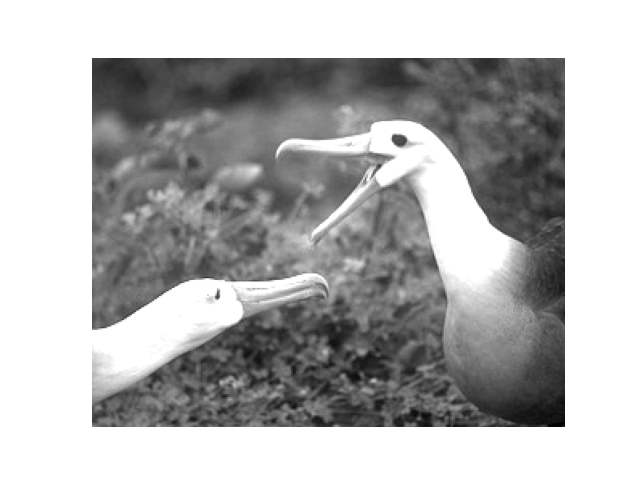

In [18]:
# load example image

# choose example image to display
scene_idx = 4

# load AllenSDK Brain Observatory project cache
cache = EcephysProjectCache.from_warehouse(manifest=MANIFEST_PATH)

# load image and show
scene = cache.get_natural_scene_template(scene_idx)
show_image(scene)

In [19]:
print(type(scene))
print(scene.shape)

<class 'numpy.ndarray'>
(918, 1174)


In [24]:
images_dir = Path(r"C:\Users\lesliec\code\visual_encoding\natural_scene_templates")
images = list(images_dir.glob('*.tiff'))

In [26]:
img_test = np.asarray(Image.open(images[2]))
print(type(img_test))
print(img_test.shape)

<class 'numpy.ndarray'>
(918, 1174)


<IPython.core.display.Javascript object>


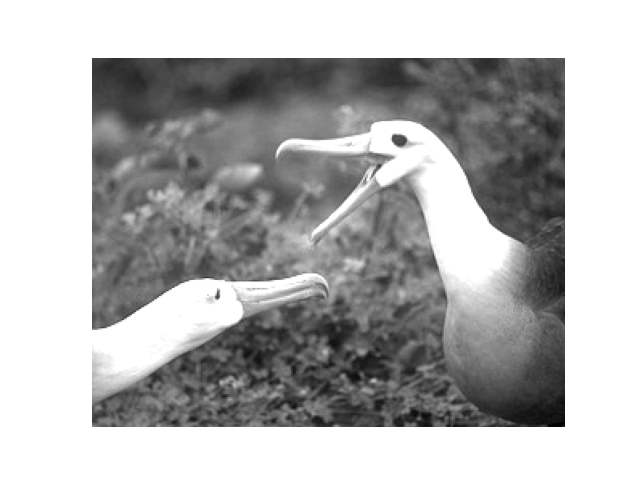

In [27]:
show_image(img_test)